<a href="https://colab.research.google.com/github/Kannakattisanjana/Detection_of_malicious_traffic_in_DoH/blob/main/doh(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import sklearn.externals
import joblib 
import IPython.display 
import sklearn.tree 
import pydotplus
import os
from sklearn.metrics import plot_confusion_matrix,plot_roc_curve
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.preprocessing import StandardScaler # Import for standard scaling of the data
from sklearn.preprocessing import MinMaxScaler 

### dataset Details
The dataset used for this research is the CIRA-CIC-DoHBrw-2020 df developed by the Canadian Institute of Cybersecurity.
This df can be found on : ```https://www.unb.ca/cic/dfs/dohbrw-2020.html```

The CIRA-CIC-DoHBrw-2020 df provides 10 days of network traffic from Monday, December 10 to Thursday December 20, 2019. The df consists of 371,836 labelled network flows consisting of 34 features (MontazeriShatoori, et al., 2020).


In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# importing the df and outputting the first 5 samples in the df
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/main(BM).csv")
print(df.shape)
df.head(5)

(269643, 36)


Unnamed: 0         SourceIP    DestinationIP  SourcePort  DestinationPort  \
0           0   192.168.20.191  176.103.130.131       50749              443   
1           1   192.168.20.191  176.103.130.131       50749              443   
2           2   192.168.20.191  176.103.130.131       50749              443   
3           3   192.168.20.191  176.103.130.131       50749              443   
4           4  176.103.130.131   192.168.20.191         443            50749   

             TimeStamp    Duration  FlowBytesSent  FlowSentRate  \
0  2020-01-14 15:49:11   95.081550          62311    655.342703   
1  2020-01-14 15:50:52  122.309318          93828    767.136973   
2  2020-01-14 15:52:55  120.958413          38784    320.639127   
3  2020-01-14 15:54:56  110.501080          61993    561.017141   
4  2020-01-14 15:56:46   54.229891          83641   1542.341289   

   FlowBytesReceived  ...  PacketTimeCoefficientofVariation  \
0              65358  ...                          0.574626   
1             101232  ...                          0.509047   
2              38236  ...                          0.732636   
3              69757  ...                          0.646859   
4              76804  ...                          0.507334   

   ResponseTimeTimeVariance  ResponseTimeTimeStandardDeviation  \
0                  0.001053                           0.032457   
1                  0.001170                           0.034200   
2                  0.000785                           0.028021   
3                  0.000411                           0.020274   
4                  0.079079                           0.281209   

   ResponseTimeTimeMean  ResponseTimeTimeMedian  ResponseTimeTimeMode  \
0              0.027624                0.026854              0.026822   
1              0.024387                0.021043              0.026981   
2              0.029238                0.026922              0.026855   
3              0.019925                0.019268              0.026918   
4              0.025930                0.000046              0.000021   

   ResponseTimeTimeSkewFromMedian  ResponseTimeTimeSkewFromMode  \
0                        0.071187                      0.024715   
1                        0.293297                     -0.075845   
2                        0.248064                      0.085061   
3                        0.097199                     -0.344926   
4                        0.276133                      0.092135   

   ResponseTimeTimeCoefficientofVariation   Label  
0                                1.174948  Benign  
1                                1.402382  Benign  
2                                0.958348  Benign  
3                                1.017535  Benign  
4                               10.844829  Benign  

[5 rows x 36 columns]

In [31]:
# Analyzing the target class to see how balanced or unbalanced the dataset is.
print(df.groupby('Label').size())

Label
Benign        19807
Malicious    249836
dtype: int64


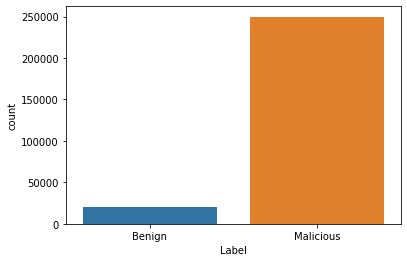

In [32]:
sns.countplot(x='Label', data=df);

In [33]:
#checking for the null values and removong.
null = df.isnull()
# print(df.isnull().any().any())
# print(null.sum())
df['ResponseTimeTimeMedian'] = df['ResponseTimeTimeMedian'].fillna(0)
df['ResponseTimeTimeSkewFromMedian'] = df['ResponseTimeTimeSkewFromMedian'].fillna(0)
null = df.isnull()
# print("New: ", df.isnull().any().any())

# print("New: ", null.sum())

### Data Preparation
In this phase, The removal of features with insignificant values was carried out . These features were, Source IP, Destination IP, Packet Time Mode and Timestamp. You may ask, why were these features chosen. Well, Source IP and Destination IP were dropped from the df because in a practical sense, numerous applications exist that randomly generate IP addresses making it not a good feature in training an anomaly detection system. So instead of targeting those features, the machine learning model was trained using data that replicates the behavior of DNS tunneling on the DoH protocol. Timestamp on the other hand was removed because it was observed that it had a high correlation with the target variable. To prevent data leakage, timestamp was removed as a feature. 

In [34]:
# df.head()

In [35]:
df = df.drop(labels = ['Unnamed: 0','SourceIP','DestinationIP','SourcePort','DestinationPort'], axis = 1)



In [36]:
# df.columns


In [37]:
# df.info(5)

In [38]:
df[df.isnull().any(axis=1)]

Empty DataFrame
Columns: [TimeStamp, Duration, FlowBytesSent, FlowSentRate, FlowBytesReceived, FlowReceivedRate, PacketLengthVariance, PacketLengthStandardDeviation, PacketLengthMean, PacketLengthMedian, PacketLengthMode, PacketLengthSkewFromMedian, PacketLengthSkewFromMode, PacketLengthCoefficientofVariation, PacketTimeVariance, PacketTimeStandardDeviation, PacketTimeMean, PacketTimeMedian, PacketTimeMode, PacketTimeSkewFromMedian, PacketTimeSkewFromMode, PacketTimeCoefficientofVariation, ResponseTimeTimeVariance, ResponseTimeTimeStandardDeviation, ResponseTimeTimeMean, ResponseTimeTimeMedian, ResponseTimeTimeMode, ResponseTimeTimeSkewFromMedian, ResponseTimeTimeSkewFromMode, ResponseTimeTimeCoefficientofVariation, Label]
Index: []

[0 rows x 31 columns]

In [39]:
# removal of data samples that contained Na or duplicates
df = df.dropna()
df = df.drop_duplicates()

In [40]:

"""
#Converting object variables to category var
columns = ["SourceIP", "DestinationIP", "Label"]

for col in columns:
    df[col] = df[col].astype('category')"""



'\n#Converting object variables to category var\ncolumns = ["SourceIP", "DestinationIP", "Label"]\n\nfor col in columns:\n    df[col] = df[col].astype(\'category\')'

In [41]:
df.info(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269637 entries, 0 to 269642
Data columns (total 31 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   TimeStamp                               269637 non-null  object 
 1   Duration                                269637 non-null  float64
 2   FlowBytesSent                           269637 non-null  int64  
 3   FlowSentRate                            269637 non-null  float64
 4   FlowBytesReceived                       269637 non-null  int64  
 5   FlowReceivedRate                        269637 non-null  float64
 6   PacketLengthVariance                    269637 non-null  float64
 7   PacketLengthStandardDeviation           269637 non-null  float64
 8   PacketLengthMean                        269637 non-null  float64
 9   PacketLengthMedian                      269637 non-null  float64
 10  PacketLengthMode                        2696

In [42]:
df_prep = df.copy()

In [43]:
df_prep.head()

TimeStamp    Duration  FlowBytesSent  FlowSentRate  \
0  2020-01-14 15:49:11   95.081550          62311    655.342703   
1  2020-01-14 15:50:52  122.309318          93828    767.136973   
2  2020-01-14 15:52:55  120.958413          38784    320.639127   
3  2020-01-14 15:54:56  110.501080          61993    561.017141   
4  2020-01-14 15:56:46   54.229891          83641   1542.341289   

   FlowBytesReceived  FlowReceivedRate  PacketLengthVariance  \
0              65358        687.388878           7474.676771   
1             101232        827.672018          10458.118598   
2              38236        316.108645           7300.293933   
3              69757        631.278898           8499.282518   
4              76804       1416.266907           8052.745751   

   PacketLengthStandardDeviation  PacketLengthMean  PacketLengthMedian  ...  \
0                      86.456213        135.673751               102.0  ...   
1                     102.264943        141.245474               114.0  ...   
2                      85.441758        133.715278                89.0  ...   
3                      92.191553        139.123548               114.0  ...   
4                      89.737092        138.913420               114.0  ...   

   PacketTimeCoefficientofVariation  ResponseTimeTimeVariance  \
0                          0.574626                  0.001053   
1                          0.509047                  0.001170   
2                          0.732636                  0.000785   
3                          0.646859                  0.000411   
4                          0.507334                  0.079079   

   ResponseTimeTimeStandardDeviation  ResponseTimeTimeMean  \
0                           0.032457              0.027624   
1                           0.034200              0.024387   
2                           0.028021              0.029238   
3                           0.020274              0.019925   
4                           0.281209              0.025930   

   ResponseTimeTimeMedian  ResponseTimeTimeMode  \
0                0.026854              0.026822   
1                0.021043              0.026981   
2                0.026922              0.026855   
3                0.019268              0.026918   
4                0.000046              0.000021   

   ResponseTimeTimeSkewFromMedian  ResponseTimeTimeSkewFromMode  \
0                        0.071187                      0.024715   
1                        0.293297                     -0.075845   
2                        0.248064                      0.085061   
3                        0.097199                     -0.344926   
4                        0.276133                      0.092135   

   ResponseTimeTimeCoefficientofVariation   Label  
0                                1.174948  Benign  
1                                1.402382  Benign  
2                                0.958348  Benign  
3                                1.017535  Benign  
4                               10.844829  Benign  

[5 rows x 31 columns]

In [44]:
cor = df_prep.corr()
cor

Duration  FlowBytesSent  FlowSentRate  \
Duration                                1.000000       0.392681     -0.048067   
FlowBytesSent                           0.392681       1.000000     -0.004253   
FlowSentRate                           -0.048067      -0.004253      1.000000   
FlowBytesReceived                       0.399265       0.805913     -0.007315   
FlowReceivedRate                       -0.068020      -0.007309      0.953705   
PacketLengthVariance                   -0.556891      -0.258483     -0.034399   
PacketLengthStandardDeviation          -0.624962      -0.292611     -0.053637   
PacketLengthMean                       -0.507772      -0.178731     -0.058906   
PacketLengthMedian                      0.385989       0.284207     -0.009113   
PacketLengthMode                        0.002822       0.025142     -0.029761   
PacketLengthSkewFromMedian             -0.227226      -0.002848     -0.014614   
PacketLengthSkewFromMode               -0.023033       0.104547      0.019611   
PacketLengthCoefficientofVariation     -0.593449      -0.277146     -0.062070   
PacketTimeVariance                      0.879834       0.315041     -0.032530   
PacketTimeStandardDeviation             0.943211       0.353735     -0.053947   
PacketTimeMean                          0.923944       0.421670     -0.036184   
PacketTimeMedian                        0.881228       0.410301     -0.027697   
PacketTimeMode                          0.251814       0.395474     -0.004937   
PacketTimeSkewFromMedian               -0.297062      -0.189563     -0.027521   
PacketTimeSkewFromMode                  0.255564       0.050093      0.000315   
PacketTimeCoefficientofVariation       -0.440264      -0.306719     -0.013899   
ResponseTimeTimeVariance                0.096747      -0.060063     -0.008514   
ResponseTimeTimeStandardDeviation       0.115583      -0.069499     -0.011702   
ResponseTimeTimeMean                    0.210721      -0.079922     -0.011573   
ResponseTimeTimeMedian                  0.213086      -0.077025     -0.010772   
ResponseTimeTimeMode                    0.160835      -0.054341     -0.007614   
ResponseTimeTimeSkewFromMedian          0.281656       0.174944     -0.196095   
ResponseTimeTimeSkewFromMode           -0.024228      -0.090523     -0.280202   
ResponseTimeTimeCoefficientofVariation  0.204090       0.444506     -0.020762   

                                        FlowBytesReceived  FlowReceivedRate  \
Duration                                         0.399265         -0.068020   
FlowBytesSent                                    0.805913         -0.007309   
FlowSentRate                                    -0.007315          0.953705   
FlowBytesReceived                                1.000000         -0.005030   
FlowReceivedRate                                -0.005030          1.000000   
PacketLengthVariance                            -0.261393         -0.010043   
PacketLengthStandardDeviation                   -0.289992         -0.034905   
PacketLengthMean                                -0.146216         -0.041789   
PacketLengthMedian                               0.381212         -0.017178   
PacketLengthMode                                 0.045748         -0.028944   
PacketLengthSkewFromMedian                      -0.017235         -0.009143   
PacketLengthSkewFromMode                         0.114319          0.022329   
PacketLengthCoefficientofVariation              -0.280947         -0.050642   
PacketTimeVariance                               0.278377         -0.046796   
PacketTimeStandardDeviation                      0.326523         -0.077006   
PacketTimeMean                                   0.409495         -0.051298   
PacketTimeMedian                                 0.401145         -0.039149   
PacketTimeMode                                   0.350021         -0.007063   
PacketTimeSkewFromMedian                        -0.194733         -0.040066   
PacketTimeSkewFromMode       

In [45]:
#sns.boxplot(x=df_prep['SourcePort'])

In [46]:
# plt.figure(figsize=(15,10))
# sns.heatmap(data=cor, annot=True)

Text(0.5, 1.0, 'Benign')

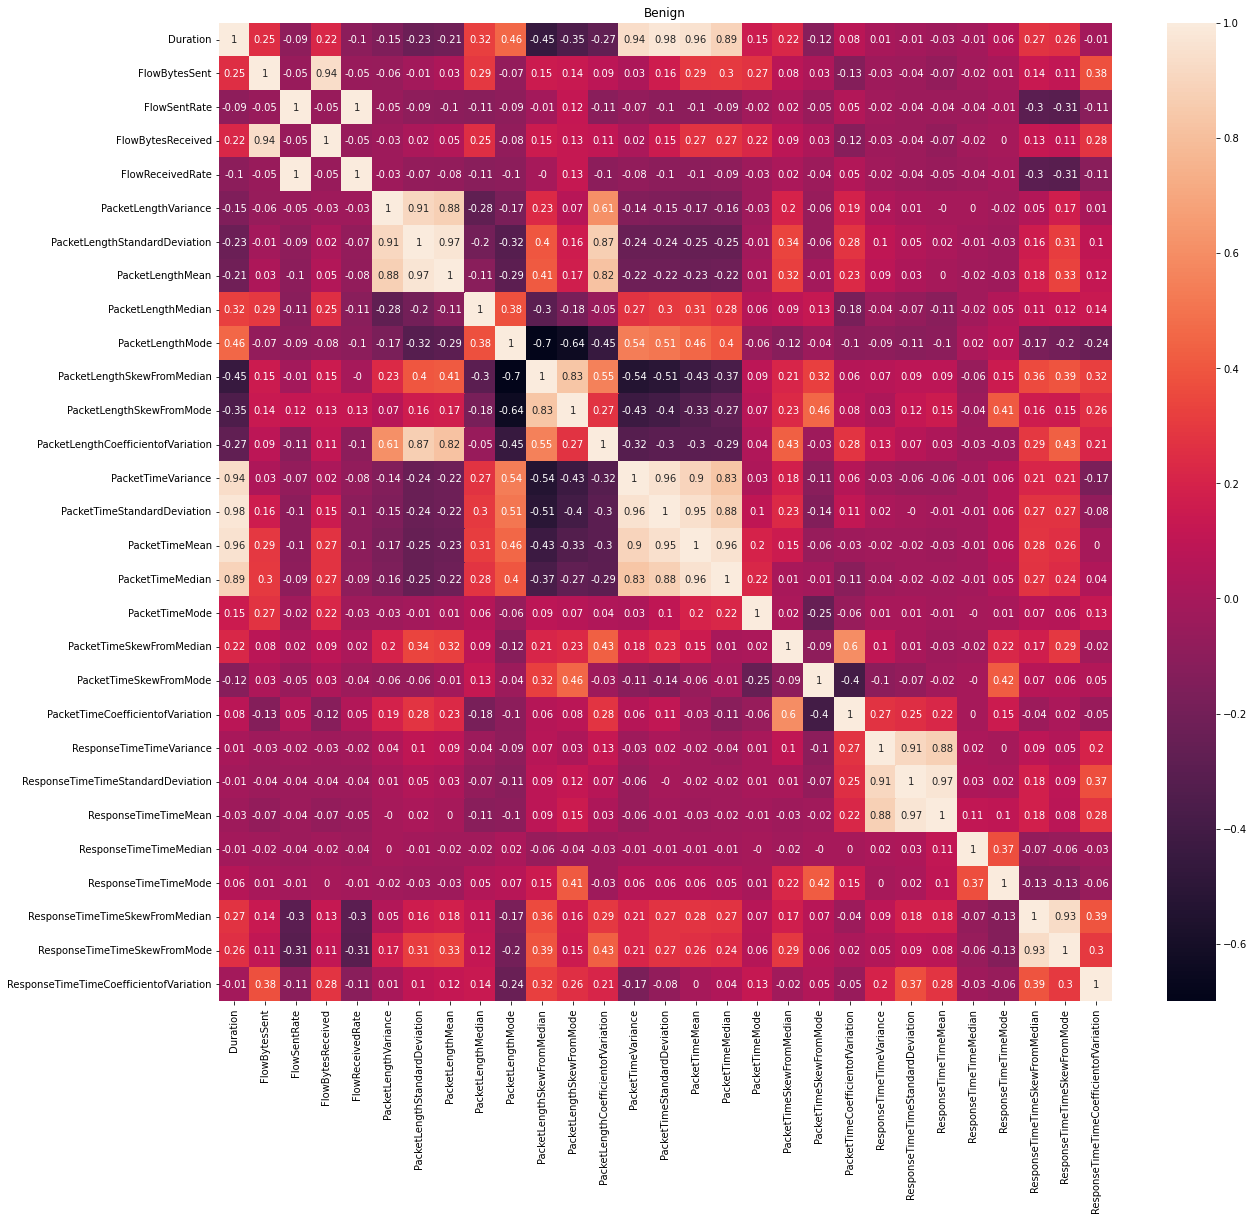

In [47]:
hep = df_prep.loc[df_prep.Label=="Benign"]

corr_mat_hep = hep.corr().round(2)
corr_mat_hep

plt.figure(figsize=(20,18))
plot = sns.heatmap(hep.corr().round(2), annot= True)
plot.set_title("Benign")

Text(0.5, 1.0, 'Malicious')

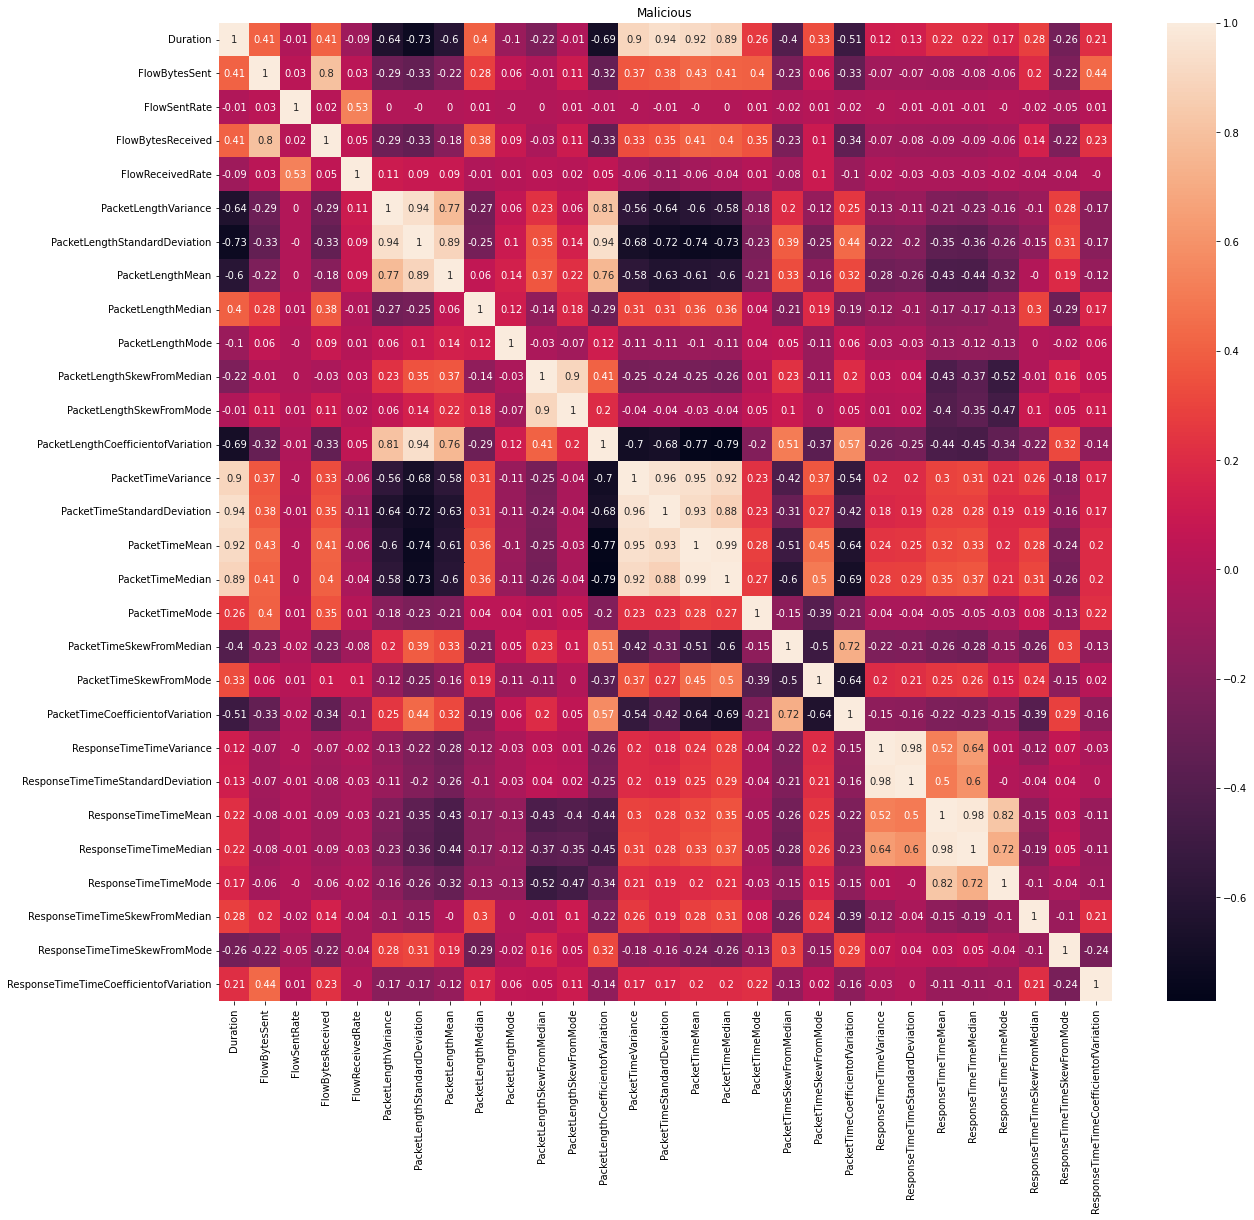

In [48]:
hep = df_prep.loc[df_prep.Label=="Malicious"]

corr_mat_hep = hep.corr().round(2)
corr_mat_hep

plt.figure(figsize=(20,18))
plot = sns.heatmap(hep.corr().round(2), annot= True)
plot.set_title("Malicious")

In [49]:
# split dataset in features and target variable

# Features
X = df_prep.drop(columns=["Label"])

# Target variable
y = df_prep['Label']

In [50]:
# import sklearn packages for data treatments
from sklearn.model_selection import train_test_split # Import train_test_split function

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [51]:
X_train.shape

(188745, 30)

In [52]:
y_train.shape

(188745,)

In [53]:
X_test.shape

(80892, 30)

In [54]:
y_test.shape

(80892,)

In [55]:
X_train_temp = X_train.copy()
X_train_temp = X_train_temp.drop(['TimeStamp'],axis=1)
X_test_temp = X_test.copy()
X_test_temp = X_test_temp.drop(['TimeStamp'],axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


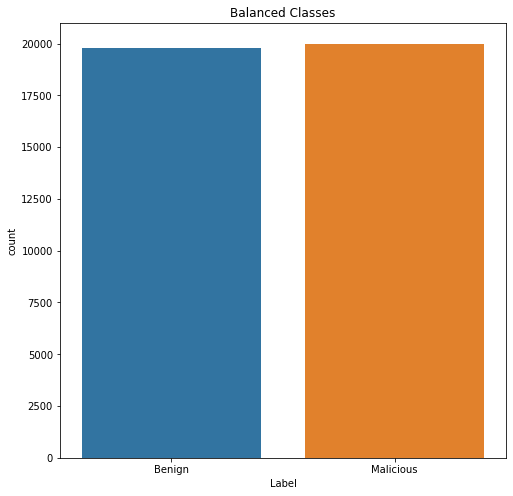

In [56]:
shuffled_df = df_prep.drop(['TimeStamp'],axis=1).sample(frac=1,random_state=4)

Benign_df = shuffled_df.loc[shuffled_df['Label'] == 'Benign']

shuffled_df.shape
Malicious_df = shuffled_df.loc[shuffled_df['Label'] == 'Malicious'].sample(n=20000,random_state=42)

normalized_df = pd.concat([Benign_df, Malicious_df])

plt.figure(figsize=(8, 8))
sns.countplot('Label', data=normalized_df)
plt.title('Balanced Classes')
plt.show()

In [57]:
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import StandardScaler # Import for standard scaling of the data
from sklearn.preprocessing import MinMaxScaler # Import for standard scaling of the data

# standard scale data
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train_temp)
X_test_scaled = ss.transform(X_test_temp)

# tested MinMaxScaler as KNN historically does better with MinMax
mm = MinMaxScaler()
X_train_mm_scaled = ss.fit_transform(X_train_temp)
X_test_mm_scaled = ss.transform(X_test_temp)

# program to run multilple models though sklearn 
# Default settings output accuracy and classification report
# compares accuracy for scaled and unscaled data
def run_models(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame):
    
    models = [          
          ('Random Forest', RandomForestClassifier(random_state=2020)),
          ('Decision Tree', DecisionTreeClassifier())
        ]  
    
    for name, model in models:        
        # unscaled data
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        # scaled data
        clf_scaled = model.fit(X_train_scaled, y_train)
        y_pred_scaled = clf_scaled.predict(X_test_scaled)
        
        # mm scaled data
        clf_mm_scaled = model.fit(X_train_mm_scaled, y_train)
        y_pred_mm_scaled = clf_scaled.predict(X_test_mm_scaled)
        
        # accuracy scores
        accuracy = round(metrics.accuracy_score(y_test, y_pred),5)
        scaled_accuracy = round(metrics.accuracy_score(y_test, y_pred_scaled),5)
        scaled_mm_accuracy = round(metrics.accuracy_score(y_test, y_pred_mm_scaled),5)
        
        # output
        print(name + ':')        
        print("---------------------------------------------------------------")      
        print("Accuracy:", accuracy)
        print("Accuracy w/Scaled Data (ss):", scaled_accuracy)
        print("Accuracy w/Scaled Data (mm):", scaled_mm_accuracy)
        if (accuracy > scaled_accuracy) and (accuracy > scaled_mm_accuracy):
            print("\nClassification Report:\n", metrics.classification_report(y_test, y_pred))      
            print("                            -----------------------------------               \n")      
        elif (scaled_accuracy > scaled_mm_accuracy):
            print("\nClassification Report (ss):\n", metrics.classification_report(y_test, y_pred_scaled))      
            print("                            -----------------------------------               \n")     
        else:            
            print("\nClassification Report (mm):\n", metrics.classification_report(y_test, y_pred_mm_scaled))      
            print("                            -----------------------------------               \n")     

In [58]:
run_models(X_train_temp, y_train, X_test_temp, y_test)

Random Forest:
---------------------------------------------------------------
Accuracy: 0.99984
Accuracy w/Scaled Data (ss): 0.99985
Accuracy w/Scaled Data (mm): 0.99985

Classification Report (mm):
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      6052
   Malicious       1.00      1.00      1.00     74840

    accuracy                           1.00     80892
   macro avg       1.00      1.00      1.00     80892
weighted avg       1.00      1.00      1.00     80892

                            -----------------------------------               

Decision Tree:
---------------------------------------------------------------
Accuracy: 0.99963
Accuracy w/Scaled Data (ss): 0.99959
Accuracy w/Scaled Data (mm): 0.99963

Classification Report (mm):
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      6052
   Malicious       1.00      1.00      1.00     74840

    accuracy               

In [59]:
models = []
models.append(('ETC', ExtraTreesClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('DT', DecisionTreeClassifier()))

print(models)



[('ETC', ExtraTreesClassifier()), ('RFC', RandomForestClassifier()), ('DT', DecisionTreeClassifier())]


In [60]:
results = []
names = []
for name, model in models:
        kfold = model_selection.KFold(n_splits=5, random_state=28, shuffle = True)
        cv_results = model_selection.cross_val_score(model, X_train_temp, y_train, cv=kfold)
        print(cv_results)
        results.append(cv_results)
        names.append(name)
        msg = "%s Accuracy: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

[0.99962913 0.99957615 0.9997086  0.99949668 0.99957615]
ETC Accuracy: 0.999597 (+/- 0.000070)
[0.99978807 0.99984106 0.99986755 0.99984106 0.99992053]
RFC Accuracy: 0.999852 (+/- 0.000043)
[0.99968211 0.99965562 0.99960264 0.99965562 0.99952317]
DT Accuracy: 0.999624 (+/- 0.000057)


In [61]:
from sklearn import metrics

clf = model.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print("\nClassification Report:\n", metrics.classification_report(y_test, y_pred)) 


Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      6052
   Malicious       1.00      1.00      1.00     74840

    accuracy                           1.00     80892
   macro avg       1.00      1.00      1.00     80892
weighted avg       1.00      1.00      1.00     80892



In [62]:
X = X.drop('TimeStamp',axis=1)

In [63]:
X_train = X_train.drop('TimeStamp',axis=1)

In [64]:
# Create Decision Tree classifer object with optimized parameters    ###feature imp
clf = RandomForestClassifier(criterion='entropy',
               n_estimators=52,
              max_depth = 100,              
              max_features='auto',
              min_samples_split=5,
              random_state=1010)

# Train Decision Tree Classifer
clf = clf.fit(X_train_temp,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_temp)

In [65]:
from sklearn.inspection import permutation_importance
feature_names = [f"feature {i}" for i in range(X.shape[1])]
result = permutation_importance(
    clf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=5
)


In [66]:
forest_importances = pd.Series(result.importances_mean, index=feature_names)

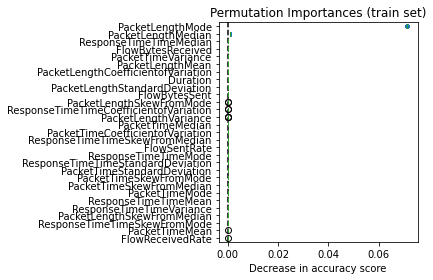

In [67]:
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [68]:
forest_importances

feature 0     3.178892e-06
feature 1     2.649077e-06
feature 2     0.000000e+00
feature 3     9.006861e-06
feature 4    -4.768338e-06
feature 5     5.298154e-07
feature 6     3.178892e-06
feature 7     6.887600e-06
feature 8     1.090360e-03
feature 9     7.130520e-02
feature 10   -2.649077e-06
feature 11    1.059631e-06
feature 12    3.178892e-06
feature 13    6.887600e-06
feature 14    0.000000e+00
feature 15   -4.768338e-06
feature 16    0.000000e+00
feature 17    0.000000e+00
feature 18    0.000000e+00
feature 19    0.000000e+00
feature 20    0.000000e+00
feature 21   -2.119261e-06
feature 22    0.000000e+00
feature 23   -2.119261e-06
feature 24    5.192191e-05
feature 25    0.000000e+00
feature 26    0.000000e+00
feature 27   -3.178892e-06
feature 28    1.059631e-06
dtype: float64

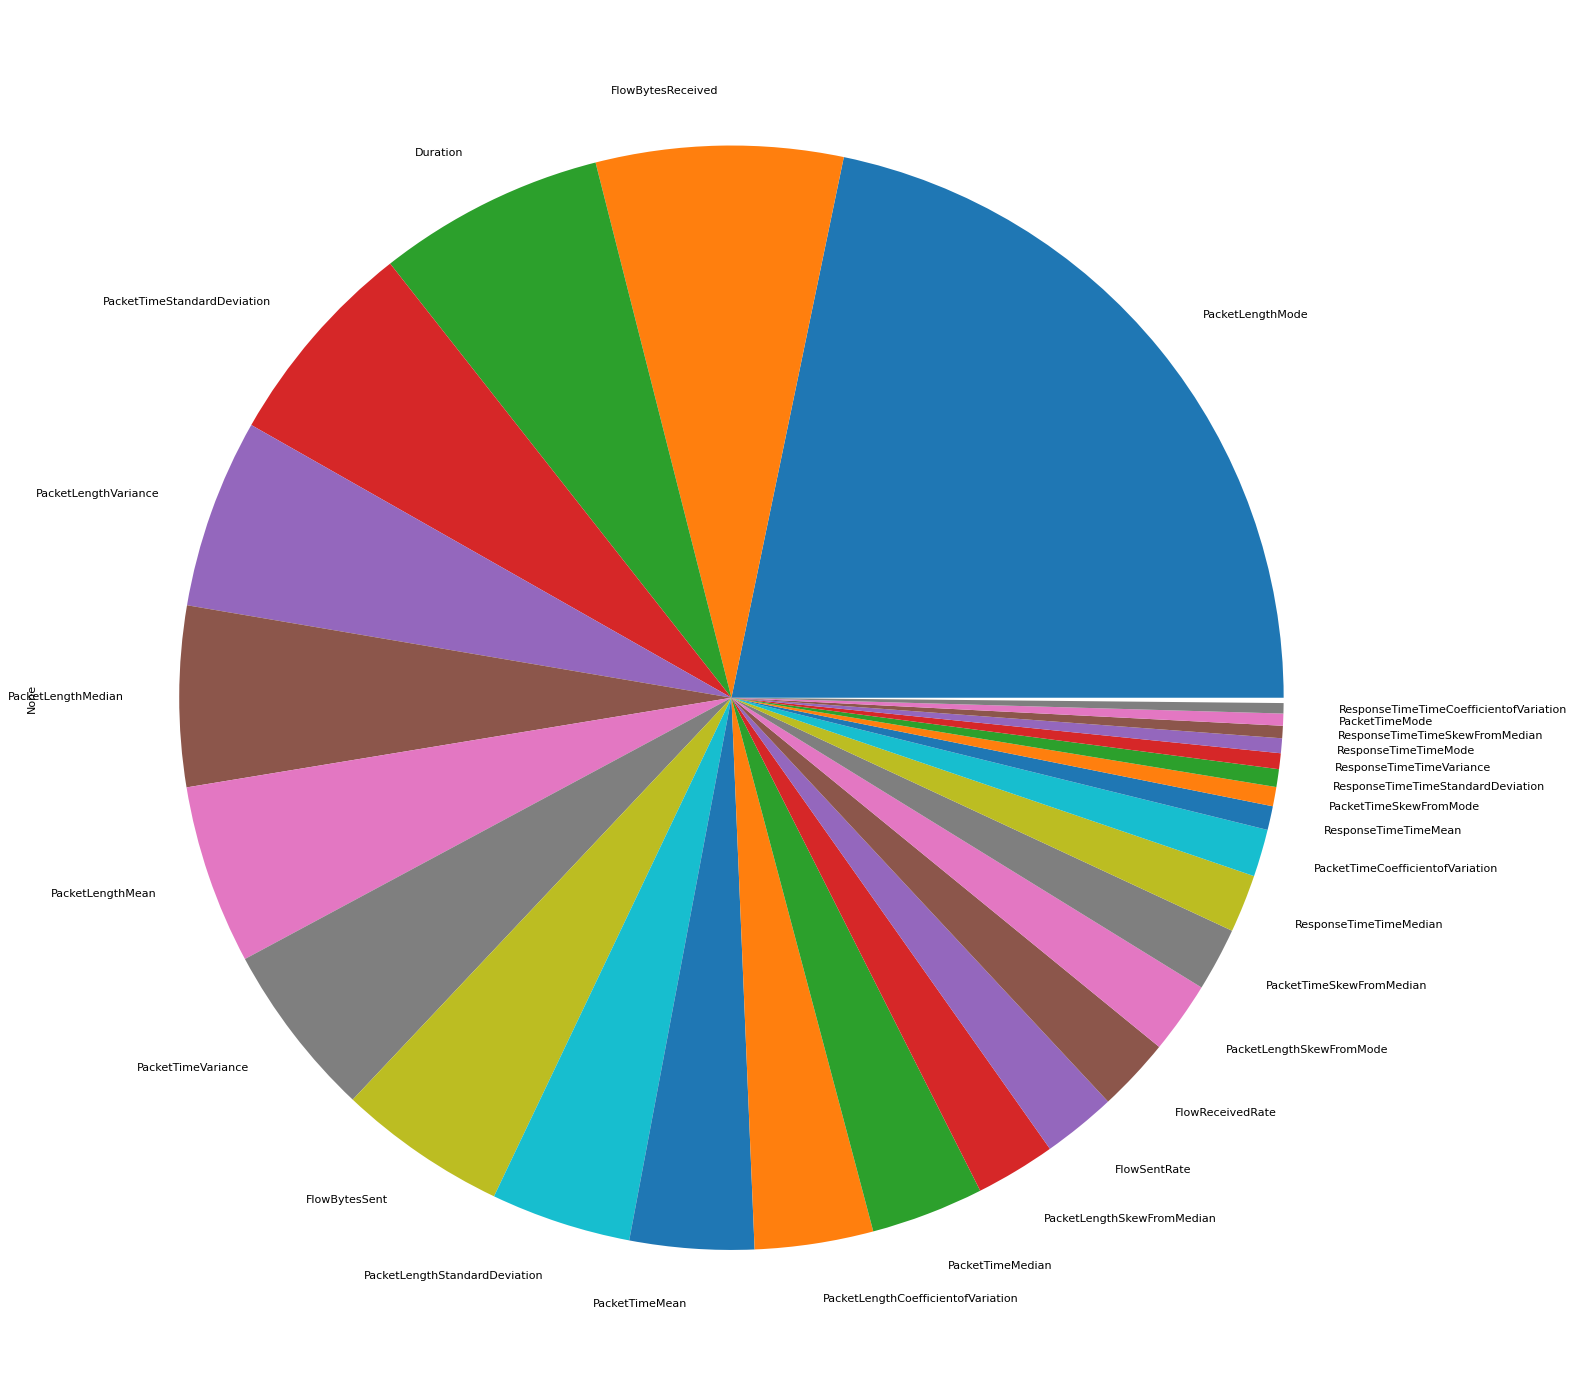

In [89]:
# for feature selection
fig = plt.figure(num=None, figsize=(20, 22), dpi=80, facecolor='w', edgecolor='w')
feat_importances = pd.Series(clf.feature_importances_, index= X.columns).sort_values(ascending=True)
feat_importances.nlargest(28).plot(kind='pie')
#sns.barplot(y=feature_imp.index, x=feature_imp)

# Add labels to your graph
plt.xticks(rotation=45, horizontalalignment='right')
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()




RFC result 30% test set
0.9997651189239974
RFC accuracy test:
 0.9997651189239974

Confusion Matrix:
 [[ 6048     4]
 [   15 74825]]

Classfication report:
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      6052
   Malicious       1.00      1.00      1.00     74840

    accuracy                           1.00     80892
   macro avg       1.00      1.00      1.00     80892
weighted avg       1.00      1.00      1.00     80892

Validating Feature importance
[0.06028483 0.0508363  0.04970578 0.07266213 0.02406089 0.03184162
 0.02805621 0.03042213 0.05713533 0.19368352 0.01309081 0.0234877
 0.02608936 0.06286737 0.0545785  0.05220976 0.0645442  0.00319159
 0.0154453  0.0096877  0.00759216 0.00562935 0.01033277 0.00866367
 0.01511951 0.00438015 0.00964811 0.00977022 0.00498302]


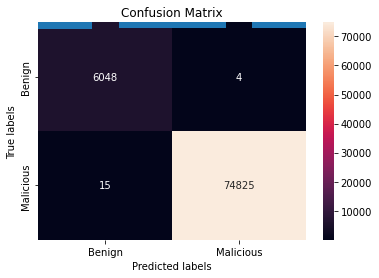

In [71]:
print("RFC result 30% test set")
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train_temp, y_train)
filename = 'finalized_RFC_model.sav'
joblib.dump(rfc, filename)
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test_temp, y_test)
print (result)

predictions_rfc = rfc.predict(X_test_temp)
print("RFC accuracy test:\n",accuracy_score(y_test, predictions_rfc))
print("\nConfusion Matrix:\n",confusion_matrix(y_test, predictions_rfc))
print("\nClassfication report:\n",classification_report(y_test, predictions_rfc))

from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     
cf_matrix=confusion_matrix(y_test, predictions_rfc)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Benign', 'Malicious']); ax.yaxis.set_ticklabels(['Benign', 'Malicious']);
cf_matrix=confusion_matrix(y_test, predictions_rfc)

#import scikitplot as skplt #to make things easy
#y_pred_proba = rfc.predict_proba(X_test_temp)
#skplt.metrics.plot_roc(y_test, y_pred_proba)
#plt.show()

print ("Validating Feature importance")
# fit an Extra Trees model to the data
test_model = RandomForestClassifier()
test_model.fit(X_train_temp, y_train)
# display the relative importance of each attribute
print(test_model.feature_importances_)
# plot
plt.bar(range(len(test_model.feature_importances_)), test_model.feature_importances_)
plt.show()



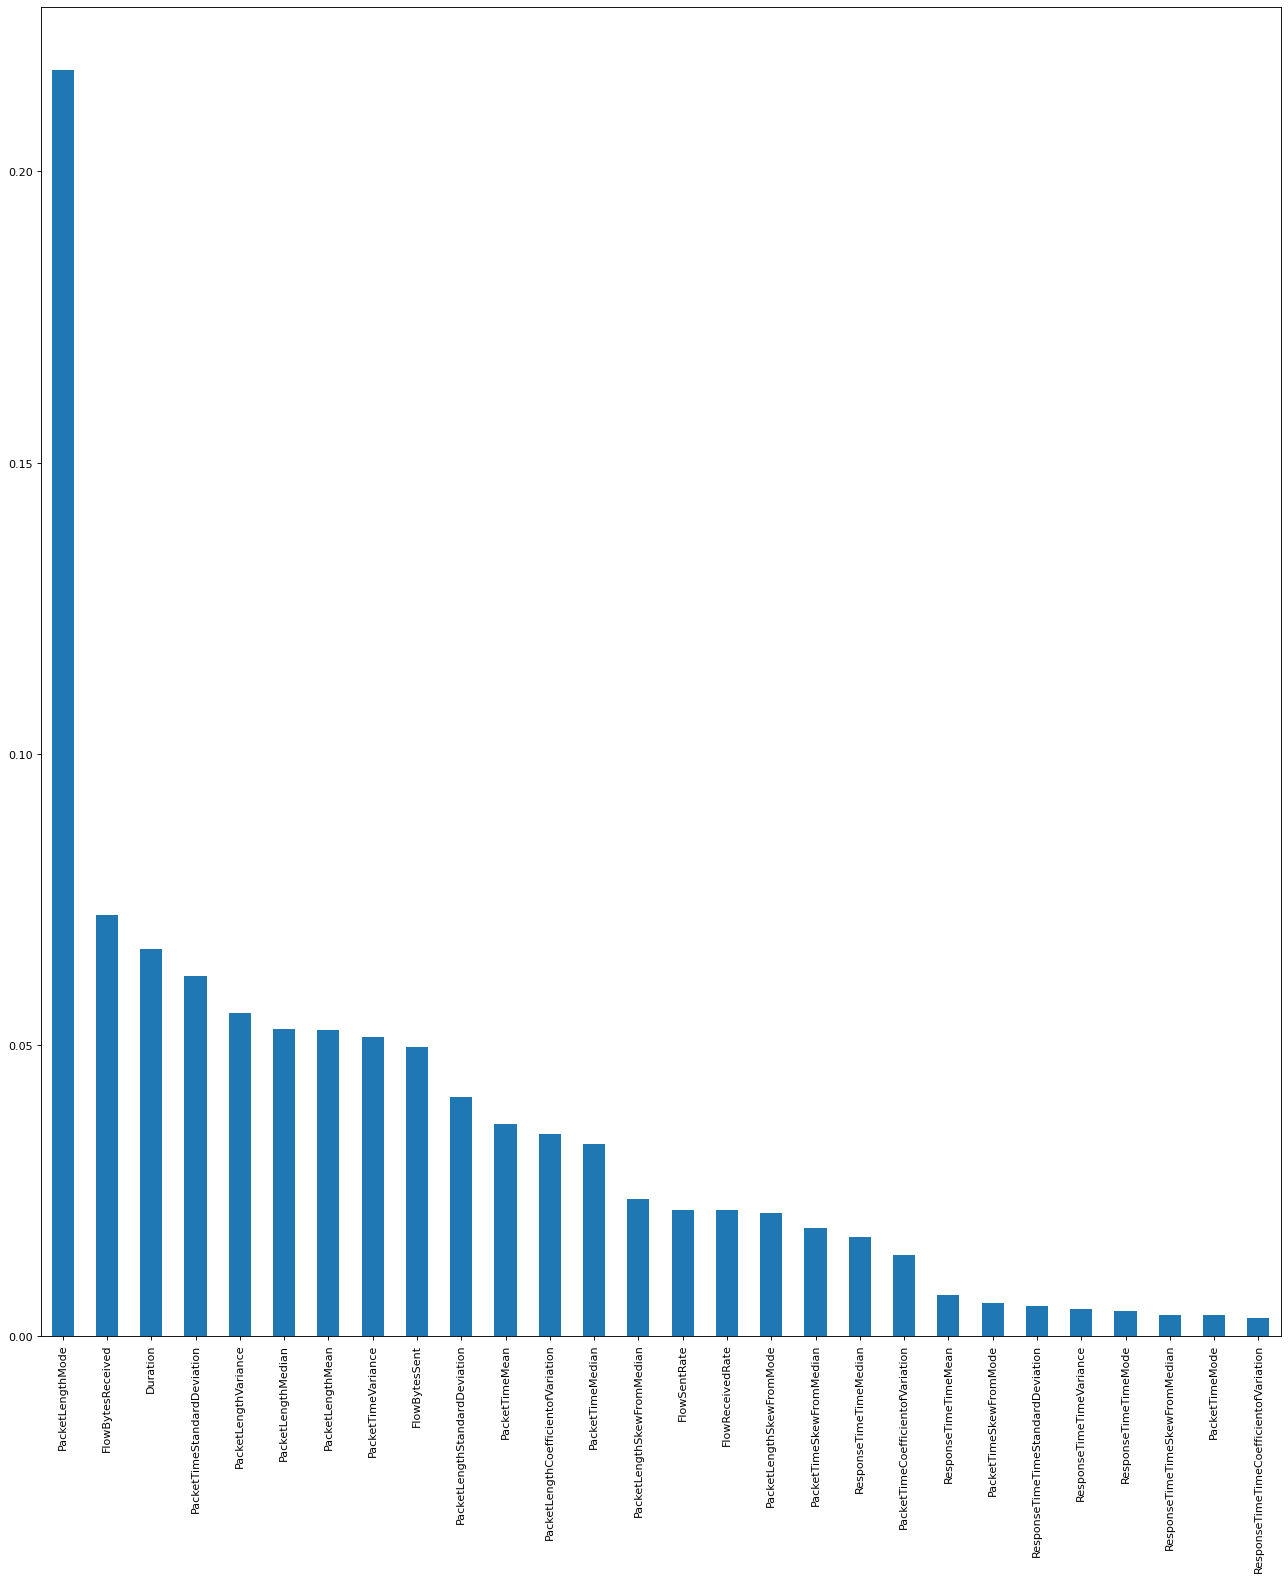

In [83]:
# for feature selection
fig = plt.figure(num=None, figsize=(20, 22), dpi=80, facecolor='w', edgecolor='k')
feat_importances = pd.Series(clf.feature_importances_, index= X.columns).sort_values(ascending=True)
feat_importances.nlargest(28).plot(kind='bar')


